In [1]:
import sys, os; sys.path.insert(1, os.path.join(sys.path[0], '..'))
import torch
from torch.utils.data import Dataset
from torch.nn import Module, Linear, BatchNorm1d, ReLU, ModuleList, Dropout
import numpy as np
import optuna
from optuna.trial import TrialState
from time import time
from tqdm import trange
from math import inf
import joblib
from torch.utils.tensorboard import SummaryWriter

from games.vortex import Vortex_5

In [2]:
# td1 = torch.load(os.path.join("../checkpoints/Vortex_5_mctspt-VorNetBN", "training.data"))
# td2 = torch.load(os.path.join("../checkpoints/Vortex_5_mctspt-VorNetBN_1", "training.data"))

# td = {}
# td['training_data'] = np.concatenate([td1['training_data'],td2['training_data']])

# torch.save(td, "../checkpoints/train_ex/training.data")

In [3]:
class PlayoutDataset():
    def __init__(self, data):
        super(PlayoutDataset, self).__init__()
        self.data = data

    def __len__(self):
        """Get length of dataset.

        Returns:
            int: Number of vertices in the dataset.
        """
        return len(self.data)

    @classmethod    
    def get_train_val_ds(cls, data_dir, train_split=0.9):
        """Splits the data randomly and creates train and validation datasets
        """       
        data_checkpoint = torch.load(os.path.join(data_dir, "training.data"))
        data = data_checkpoint['training_data']
        data_idx = np.arange(len(data))
        np.random.shuffle(data_idx)
        val_start_idx = int(len(data) * train_split)
        train_idx, val_idx = data_idx[:val_start_idx], data_idx[val_start_idx:]
        train_data, val_data = data[train_idx], data[val_idx]

        # fix any data leakage
        hashes = set()
        for ex in train_data:
            hashes.add(ex[0].tostring())
        val_data = np.array([ex for ex in val_data if ex[0].tostring() not in hashes])

        return cls(train_data), cls(val_data)

class PlayoutLoader():
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.idx = np.arange(len(dataset))
        if shuffle:
            np.random.shuffle(self.idx)

    def __iter__(self):
        for i in range(0, len(self.idx), self.batch_size):
            idx = self.idx[i:i+self.batch_size]
            # make sure there are at least 4 examples in the batch
            if len(idx) >= 4:
                yield self.dataset.data[idx]



In [4]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
class MLP(Module):
    def __init__(self, in_features, layer0_dims, hidden_dims, hidden_layers, out_features, dropout):
        super().__init__()
        self._mlist = ModuleList([
            Linear(in_features, layer0_dims),
            BatchNorm1d(layer0_dims),
            ReLU()
        ])

        in_dim = layer0_dims        
        for i in range(hidden_layers):
            self._mlist.append(Linear(in_dim, hidden_dims))
            self._mlist.append(BatchNorm1d(hidden_dims))
            self._mlist.append(ReLU())
            self._mlist.append(Dropout(p=dropout))
            in_dim = hidden_dims
        self._mlist.append(Linear(in_dim, out_features))

    def forward(self, x):
        for layer in self._mlist:
            x = layer(x)
        return x

class VorNet(Module):
    def __init__(self, input_shape, p_shape, v_shape, policy_layers, policy_l0_dim, policy_dim, value_layers, value_l0_dim, value_dim, dropout):
        super(VorNet, self).__init__()
        self.input_shape = input_shape
        self.p_shape = p_shape
        self.v_shape = v_shape
        B, F = input_shape

        self.input_bn = BatchNorm1d(F)
        self.policy_head = MLP(F, policy_l0_dim, policy_dim, policy_layers, 1, dropout)
        self.value_head = MLP(4*F, value_l0_dim, value_dim, value_layers, np.prod(self.v_shape), dropout)

    def forward(self, x):
        B, N, F = x.shape

        x = self.input_bn(x.view(B*N, F)).view(B, N, F)

        side_nodes = x[:, -4:, :]
        x = x.view(B*N, F)
        p = self.policy_head(x)
        p = p.view(B, np.prod(self.p_shape))
        
        side_nodes = side_nodes.view(B, 4*F)
        v = self.value_head(side_nodes).tanh()

        return p, v

In [6]:
def get_valid_dist(s, logits, log_softmax=False):
    mask = torch.from_numpy(game.get_available_actions(s).astype(np.uint8)).bool()
    mask = mask.cuda()
    selection = torch.masked_select(logits, mask)
    dist = torch.nn.functional.log_softmax(selection, dim=-1)
    if log_softmax:
        return dist
    return torch.exp(dist)

def calc_loss(states, prediction, target):
    batch_size = len(states)
    p_pred, v_pred = prediction
    p_gt, v_gt = target
    v_gt = torch.from_numpy(v_gt.astype(np.float32))
    v_gt = v_gt.cuda()
    v_loss = ((v_pred - v_gt)**2).sum() # Mean squared error
    p_loss = 0
    for i in range(batch_size):
        gt = torch.from_numpy(p_gt[i].astype(np.float32))
        gt = gt.cuda()
        s = states[i]
        logits = p_pred[i]
        pred = get_valid_dist(s, logits, log_softmax=True)
        p_loss += -torch.sum(gt*pred)
    return p_loss + v_loss


def get_batch_states(batch):
    states = np.stack(batch[:,0])
    nn_states = [s.nn_attr for s in states]
    nn_states = np.stack(nn_states)
        
    return nn_states, states

def train_step(batch, model, optimizer):
    model.train()
    nn_states, states = get_batch_states(batch)
    x = torch.from_numpy(nn_states)
    p_pred, v_pred = model(x)
    p_gt, v_gt = batch[:,1], np.stack(batch[:,2])
    loss = calc_loss(states, (p_pred, v_pred), (p_gt, v_gt))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def val_step(batch, model):
    model.eval()
    with torch.no_grad():
        nn_states, states = get_batch_states(batch)
        x = torch.from_numpy(nn_states)
        p_pred, v_pred = model(x)
        p_gt, v_gt = batch[:,1], np.stack(batch[:,2])
        loss = calc_loss(states, (p_pred, v_pred), (p_gt, v_gt))

    return loss.item()

In [7]:
DATA_DIR="../checkpoints/train_ex"
EPOCHS=3
LR=1e-3
WEIGHT_DECAY=1e-4

train_ds, val_ds = PlayoutDataset.get_train_val_ds(data_dir=DATA_DIR)
print("Training data loaded")
print("  {} train examples".format(train_ds.__len__()))
print("  {} validation examples".format(val_ds.__len__()))
game = Vortex_5()
input_shape = game.get_initial_state().shape
p_shape = game.get_available_actions(game.get_initial_state()).shape
v_shape = (game.get_num_players(),)

Training data loaded
  34991 train examples
  3229 validation examples


In [8]:
def objective(trial):
    model = VorNet(
        input_shape, 
        p_shape, 
        v_shape,
        10, #trial.suggest_int("policy_layers", 1, 15),
        trial.suggest_int("policy_l0_dim", 100, 1000),
        trial.suggest_int("policy_dim", 100, 1000),
        10, #trial.suggest_int("value_layers", 8, 20),
        trial.suggest_int("value_l0_dim", 100, 2000),
        trial.suggest_int("value_dim", 100, 1000),
        trial.suggest_float("dropout", 0.0, 0.5)
    )
    model = model.to('cuda')
    model = torch.nn.DataParallel(model)
    
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # weight_decay = lr/10
    weight_decay = trial.suggest_float("weight_decay", LR/100, LR/2)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)

    # get the data loaders
    #batch_size = trial.suggest_int("batch_size", 8, 256)
    batch_size = 256

    # Training of the model.
    best_loss = None
    for epoch in range(EPOCHS):
        train_loader = PlayoutLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
        val_loader = PlayoutLoader(dataset=val_ds, batch_size=batch_size)
        val_loss = AverageMeter()

        for batch in train_loader:
            train_step(batch, model, optimizer)
        
        for batch in val_loader:
            loss = val_step(batch, model)
            val_loss.update(loss / len(batch))

        trial.report(val_loss.avg, epoch)
        best_loss = val_loss.avg if best_loss is None else min(best_loss, val_loss.avg)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_loss

In [9]:
study = optuna.create_study(study_name="VorNet", direction="minimize")
# study = joblib.load("../checkpoints/train_ex/study.pkl")
# print("Best trial until now:")
# print(" Value: ", study.best_trial.value)
# print(" Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")

[I 2022-01-13 13:51:38,871] A new study created in memory with name: VorNet


In [10]:
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-13 13:53:07,324] Trial 0 finished with value: 3.0148119407795853 and parameters: {'policy_l0_dim': 976, 'policy_dim': 994, 'value_l0_dim': 553, 'value_dim': 337, 'dropout': 0.1974815212830684, 'weight_decay': 0.00031882260011605897}. Best is trial 0 with value: 3.0148119407795853.
[I 2022-01-13 13:54:28,423] Trial 1 finished with value: 3.0233889804757847 and parameters: {'policy_l0_dim': 703, 'policy_dim': 287, 'value_l0_dim': 1540, 'value_dim': 287, 'dropout': 0.33401831156226874, 'weight_decay': 0.00034726991364180206}. Best is trial 0 with value: 3.0148119407795853.
[I 2022-01-13 13:55:50,975] Trial 2 finished with value: 3.0189846787366252 and parameters: {'policy_l0_dim': 696, 'policy_dim': 782, 'value_l0_dim': 1539, 'value_dim': 333, 'dropout': 0.35671535907990976, 'weight_decay': 0.0003915886886572914}. Best is trial 0 with value: 3.0148119407795853.
[I 2022-01-13 13:56:43,943] Trial 3 finished with value: 3.009603377360447 and parameters: {'policy_l0_dim': 733, 'pol

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  69
  Number of complete trials:  31
Best trial:
  Value:  3.000765025644896
  Params: 
    policy_l0_dim: 205
    policy_dim: 235
    value_l0_dim: 1692
    value_dim: 226
    dropout: 0.0008681433027716637
    weight_decay: 0.0003481859455304771


/tmp/ipykernel_2711986/2555236602.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

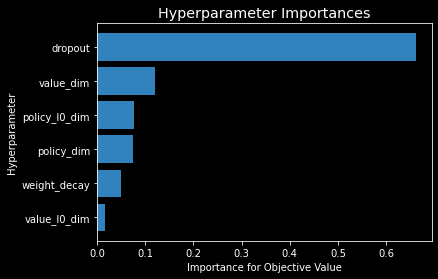

In [11]:
#optuna.visualization.matplotlib.plot_contour(study, params=['batch_size', 'lr'])
optuna.visualization.matplotlib.plot_param_importances(study)

In [12]:
joblib.dump(study, os.path.join(DATA_DIR, "study.pkl"))

['../checkpoints/train_ex/study.pkl']

In [13]:
from models.vornet import VorNet as _VorNet

model = _VorNet(input_shape, p_shape, v_shape)
model = model.to('cuda')
model = torch.nn.DataParallel(model)
EPOCHS = 10
BATCH_SIZE = 4
LR = 1e-3
WEIGHT_DECAY = 5e-4
DATA_DIR="../checkpoints/train_ex"

log_dir = os.path.join(DATA_DIR, 'logs', str(time()))
writer = SummaryWriter(log_dir=log_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Training of the model.
best_loss = None
error_log = []
for epoch in trange(EPOCHS):
    train_loader = PlayoutLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = PlayoutLoader(dataset=val_ds, batch_size=BATCH_SIZE)
    train_loss = AverageMeter()
    val_loss = AverageMeter()

    for batch in train_loader:
        loss = train_step(batch, model, optimizer)
        train_loss.update(loss / len(batch))
    
    writer.add_scalar('train loss', train_loss.avg, epoch)
    
    for batch in val_loader:
        loss = val_step(batch, model)
        val_loss.update(loss / len(batch))
    
    writer.add_scalar('val loss', val_loss.avg, epoch)

    error_log.append(val_loss)
    if (best_loss is None) or (val_loss.avg < best_loss):
        best_loss = val_loss.avg       
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'error_log': error_log,
            }, os.path.join(DATA_DIR, "0.ckpt"))
    writer.flush()

writer.close()

  0%|          | 0/10 [00:18<?, ?it/s]


KeyboardInterrupt: 